In [43]:
import timeit
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

In [44]:
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OMP_PROC_BIND"] = "close"
os.environ["OMP_PLACES"] = "cores"

In [45]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt


In [46]:
%%bash
make clean
make VERSION=kparallel_mpi

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt perf/* out*.txt
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_utils.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c m_partitioner_adapted.F90
mpif90 -ffree-line-length-none  -g1 -O3 -fno-inline -fno-optimize-sibling-calls -fno-omit-frame-pointer -march=native -funroll-loops -fopenmp -flto -fno-math-errno -c stencil2d-kparallel_mpi.F90


stencil2d-kparallel_mpi.F90:14:9:

   14 |     use m_partitioner_adapted, only: Partitioner
      |         1
Fatal Error: Cannot open module file 'm_partitioner_adapted.mod' for reading at (1): No such file or directory
compilation terminated.
make: *** [Makefile:80: stencil2d-kparallel_mpi.o] Error 1


CalledProcessError: Command 'b'make clean\nmake VERSION=kparallel_mpi\n'' returned non-zero exit status 2.

In [40]:
%%bash
srun -n 2 ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024

 #threads =            8
# ranks nx ny nz num_iter time
data = np.array( [ \
 #threads =            8
[    2,  128,  128,   64,    1024,  0.3047492E+02], \
] )


In [41]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("in_field.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Initial condition")

    out_field = read_field_from_file("out_field.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Final result")

    plt.show()

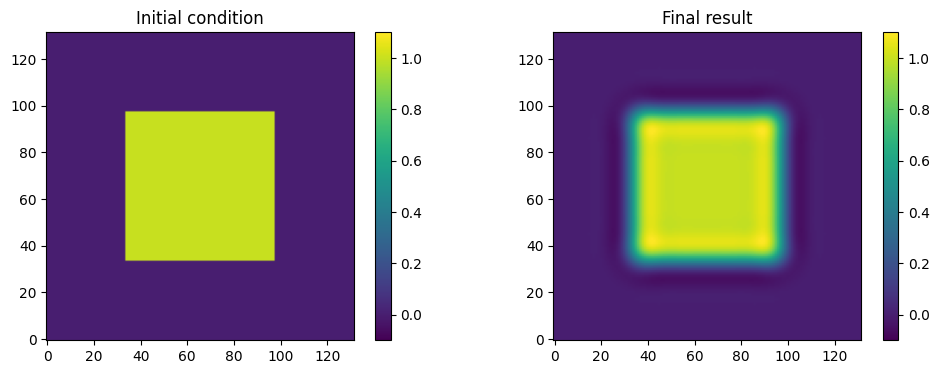

In [42]:
validate_results()

In [25]:
%%bash

echo "runtimes = [[0.0]*11 for _ in range(73)]" > out.txt

for nthreads in $(seq 1 5); do
  export OMP_NUM_THREADS=$nthreads
  ncores=$nthreads
  if [ $nthreads -gt 72 ]; then
    ncores=72
  fi

  for nnodes in $(seq 1 5); do
    echo "Running with $nthreads threads and $nnodes MPI tasks"
    
    output=$(srun -n $nnodes -c $ncores ./stencil2d-kparallel_mpi.x --nx 128 --ny 128 --nz 64 --num_iter 1024)
    runtime=$(echo "$output" | grep 'data =' | sed 's/.*\[//' | cut -d',' -f6)

    echo "runtimes[$nthreads][$nnodes] = $runtime" >> out.txt
  done
done

done

Running with 1 threads and 1 MPI tasks
Running with 1 threads and 2 MPI tasks
Running with 1 threads and 3 MPI tasks
Running with 1 threads and 4 MPI tasks
Running with 1 threads and 5 MPI tasks
Running with 2 threads and 1 MPI tasks
Running with 2 threads and 2 MPI tasks
Running with 2 threads and 3 MPI tasks
Running with 2 threads and 4 MPI tasks
Running with 2 threads and 5 MPI tasks
Running with 3 threads and 1 MPI tasks
Running with 3 threads and 2 MPI tasks
Running with 3 threads and 3 MPI tasks
Running with 3 threads and 4 MPI tasks
Running with 3 threads and 5 MPI tasks
Running with 4 threads and 1 MPI tasks
Running with 4 threads and 2 MPI tasks
Running with 4 threads and 3 MPI tasks
Running with 4 threads and 4 MPI tasks
Running with 4 threads and 5 MPI tasks
Running with 5 threads and 1 MPI tasks
Running with 5 threads and 2 MPI tasks
Running with 5 threads and 3 MPI tasks
Running with 5 threads and 4 MPI tasks
Running with 5 threads and 5 MPI tasks


In [26]:
labels = []  
times = []   

for nthreads in range(1, len(out)):
    if out[nthreads] is None:
        continue  # skip if not set
    
    ntasks = int(out[nthreads][0][0])  # column 0 = MPI ranks
    runtime = float(out[nthreads][0][5])  # column 5 = runtime
    
    labels.append((nthreads, ntasks))
    times.append(runtime)

In [13]:
exec(open("out.txt", "r").read())
labels = []
times = []
for i in range(len(out)):
    if i == 0:
        continue
    labels.append(i)
    times.append(out[i][:, 5].item())

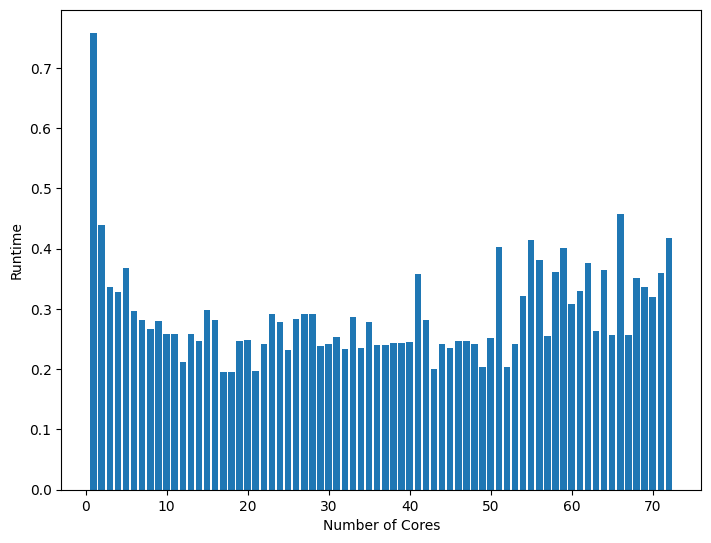

In [14]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(labels, times)
ax.set_xlabel('Number of Cores')
ax.set_ylabel('Runtime')
plt.show()

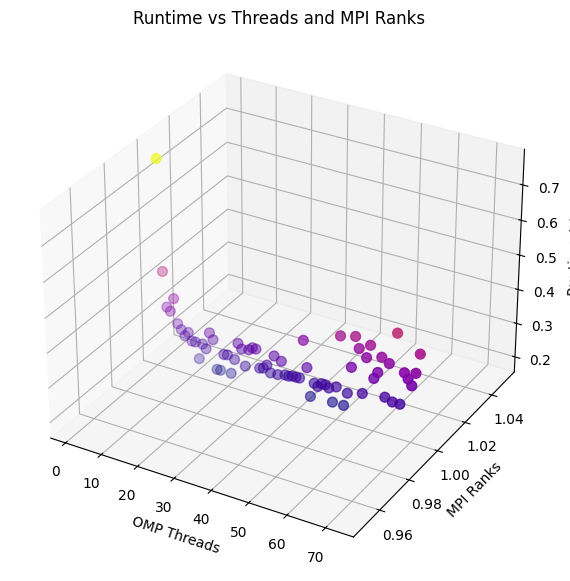

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

nthreads = [l[0] for l in labels]
ntasks = [l[1] for l in labels]

ax.scatter(nthreads, ntasks, times, c=times, cmap='plasma', s=50)

ax.set_xlabel("OMP Threads")
ax.set_ylabel("MPI Ranks")
ax.set_zlabel("Runtime (s)")
ax.set_title("Runtime vs Threads and MPI Ranks")
plt.show()